In [2]:
!pip install seaborn

^C


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Core Financial Functions

In [3]:
class TrustLendProtocol:
    """
    TrustLend DeFi Protocol Simulator
    Simulates loan lifecycle, interest calculations, and liquidation scenarios
    """
    
    def __init__(self, interest_rate=0.10, ltv_ratio=1.5, liquidation_threshold=0.75):
        self.interest_rate = interest_rate  # 10% APR
        self.ltv_ratio = ltv_ratio  # 150% collateralization
        self.liquidation_threshold = liquidation_threshold  # Liquidate at 75% LTV
        self.loans = []
    
    def calculate_collateral_required(self, loan_amount, eth_price):
        """
        Calculate required collateral in ETH
        Formula: Collateral = (Loan Amount / LTV) / ETH Price
        """
        collateral_value_usd = loan_amount * self.ltv_ratio
        collateral_eth = collateral_value_usd / eth_price
        return collateral_eth, collateral_value_usd
    
    def calculate_interest(self, loan_amount, days):
        """
        Calculate interest for a loan
        Formula: Interest = (Loan Amount × Interest Rate × Days) / 365
        """
        interest = (loan_amount * self.interest_rate * days) / 365
        return interest
    
    def calculate_current_ltv(self, loan_amount, collateral_eth, current_eth_price):
        """
        Calculate current LTV ratio based on market price
        LTV = Loan Amount / (Collateral × Current Price)
        """
        collateral_value = collateral_eth * current_eth_price
        current_ltv = loan_amount / collateral_value
        return current_ltv, collateral_value
    
    def check_liquidation(self, loan_amount, collateral_eth, current_eth_price):
        """
        Check if loan should be liquidated
        Liquidates when LTV > liquidation_threshold
        """
        current_ltv, collateral_value = self.calculate_current_ltv(
            loan_amount, collateral_eth, current_eth_price
        )
        should_liquidate = current_ltv > self.liquidation_threshold
        return should_liquidate, current_ltv, collateral_value
    
    def simulate_loan(self, loan_amount, initial_eth_price, duration_days, 
                     eth_price_volatility=0.02):
        """
        Simulate a complete loan lifecycle with price volatility
        """
        # Calculate initial collateral
        collateral_eth, initial_collateral_value = self.calculate_collateral_required(
            loan_amount, initial_eth_price
        )
        
        # Generate daily ETH price movements (random walk)
        daily_returns = np.random.normal(0, eth_price_volatility, duration_days)
        eth_prices = [initial_eth_price]
        for ret in daily_returns:
            eth_prices.append(eth_prices[-1] * (1 + ret))
        
        # Track loan metrics daily
        loan_data = []
        liquidated = False
        liquidation_day = None
        
        for day in range(duration_days + 1):
            current_price = eth_prices[day]
            current_interest = self.calculate_interest(loan_amount, day)
            total_debt = loan_amount + current_interest
            
            should_liquidate, current_ltv, collateral_value = self.check_liquidation(
                total_debt, collateral_eth, current_price
            )
            
            if should_liquidate and not liquidated:
                liquidated = True
                liquidation_day = day
            
            loan_data.append({
                'day': day,
                'eth_price': current_price,
                'collateral_value_usd': collateral_value,
                'loan_amount': loan_amount,
                'interest_accrued': current_interest,
                'total_debt': total_debt,
                'ltv_ratio': current_ltv,
                'liquidated': liquidated
            })
        
        return pd.DataFrame(loan_data), collateral_eth, liquidated, liquidation_day

# Initialize protocol
protocol = TrustLendProtocol()
print("✅ TrustLend Protocol initialized")
print(f"   Interest Rate: {protocol.interest_rate * 100}% APR")
print(f"   LTV Ratio: {protocol.ltv_ratio * 100}%")
print(f"   Liquidation Threshold: {protocol.liquidation_threshold * 100}%")

✅ TrustLend Protocol initialized
   Interest Rate: 10.0% APR
   LTV Ratio: 150.0%
   Liquidation Threshold: 75.0%


## 2. Single Loan Simulation Example

In [4]:
# Loan parameters
LOAN_AMOUNT = 5000  # 5,000 TDAI
ETH_PRICE = 2500    # $2,500 per ETH
DURATION = 365      # 1 year

# Simulate loan
loan_df, collateral_eth, is_liquidated, liquidation_day = protocol.simulate_loan(
    loan_amount=LOAN_AMOUNT,
    initial_eth_price=ETH_PRICE,
    duration_days=DURATION,
    eth_price_volatility=0.02  # 2% daily volatility
)

# Calculate final metrics
final_interest = loan_df.iloc[-1]['interest_accrued']
final_debt = loan_df.iloc[-1]['total_debt']
final_ltv = loan_df.iloc[-1]['ltv_ratio']
final_eth_price = loan_df.iloc[-1]['eth_price']
final_collateral_value = loan_df.iloc[-1]['collateral_value_usd']

print("="*60)
print("LOAN SIMULATION RESULTS")
print("="*60)
print(f"\n📊 Initial Setup:")
print(f"   Loan Amount: {LOAN_AMOUNT:,.0f} TDAI")
print(f"   Initial ETH Price: ${ETH_PRICE:,.2f}")
print(f"   Required Collateral: {collateral_eth:.4f} ETH (${collateral_eth * ETH_PRICE:,.2f})")
print(f"   Duration: {DURATION} days")

print(f"\n💰 Final Results (Day {DURATION}):")
print(f"   Final ETH Price: ${final_eth_price:,.2f}")
print(f"   Collateral Value: ${final_collateral_value:,.2f}")
print(f"   Interest Accrued: {final_interest:,.2f} TDAI")
print(f"   Total Debt: {final_debt:,.2f} TDAI")
print(f"   Final LTV: {final_ltv:.2%}")

if is_liquidated:
    print(f"\n⚠️  LIQUIDATION OCCURRED on Day {liquidation_day}")
    liquidation_price = loan_df[loan_df['day'] == liquidation_day]['eth_price'].values[0]
    print(f"   Liquidation ETH Price: ${liquidation_price:,.2f}")
    print(f"   Price Drop: {((liquidation_price - ETH_PRICE) / ETH_PRICE * 100):.2f}%")
else:
    print(f"\n✅ Loan completed successfully (No liquidation)")
    profit_loss = final_collateral_value - final_debt
    print(f"   Borrower Net Position: ${profit_loss:,.2f}")

print("\n" + "="*60)

LOAN SIMULATION RESULTS

📊 Initial Setup:
   Loan Amount: 5,000 TDAI
   Initial ETH Price: $2,500.00
   Required Collateral: 3.0000 ETH ($7,500.00)
   Duration: 365 days

💰 Final Results (Day 365):
   Final ETH Price: $1,880.34
   Collateral Value: $5,641.02
   Interest Accrued: 500.00 TDAI
   Total Debt: 5,500.00 TDAI
   Final LTV: 97.50%

⚠️  LIQUIDATION OCCURRED on Day 109
   Liquidation ETH Price: $2,220.63
   Price Drop: -11.17%



## 3. Visualize Loan Lifecycle

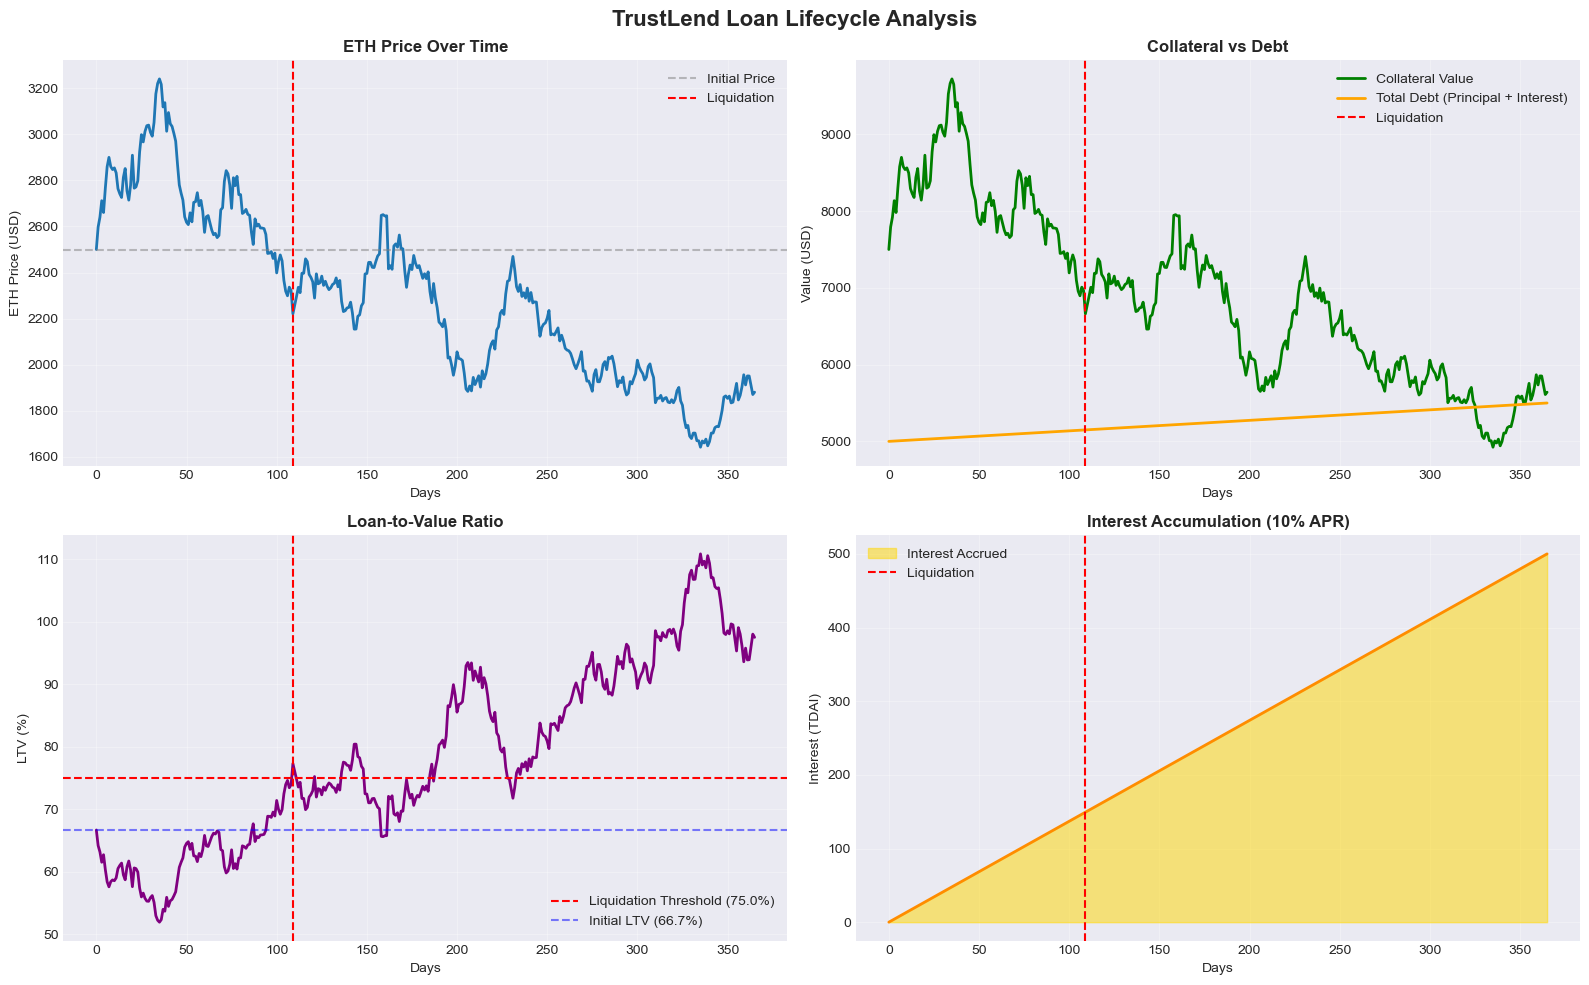

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('TrustLend Loan Lifecycle Analysis', fontsize=16, fontweight='bold')

# 1. ETH Price Movement
axes[0, 0].plot(loan_df['day'], loan_df['eth_price'], linewidth=2, color='#1f77b4')
axes[0, 0].axhline(y=ETH_PRICE, color='gray', linestyle='--', alpha=0.5, label='Initial Price')
if is_liquidated:
    axes[0, 0].axvline(x=liquidation_day, color='red', linestyle='--', label='Liquidation')
axes[0, 0].set_title('ETH Price Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('ETH Price (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Collateral Value vs Total Debt
axes[0, 1].plot(loan_df['day'], loan_df['collateral_value_usd'], 
                label='Collateral Value', linewidth=2, color='green')
axes[0, 1].plot(loan_df['day'], loan_df['total_debt'], 
                label='Total Debt (Principal + Interest)', linewidth=2, color='orange')
if is_liquidated:
    axes[0, 1].axvline(x=liquidation_day, color='red', linestyle='--', label='Liquidation')
axes[0, 1].set_title('Collateral vs Debt', fontweight='bold')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Value (USD)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. LTV Ratio
axes[1, 0].plot(loan_df['day'], loan_df['ltv_ratio'] * 100, linewidth=2, color='purple')
axes[1, 0].axhline(y=protocol.liquidation_threshold * 100, color='red', 
                   linestyle='--', label=f'Liquidation Threshold ({protocol.liquidation_threshold*100}%)')
axes[1, 0].axhline(y=(1/protocol.ltv_ratio) * 100, color='blue', 
                   linestyle='--', label=f'Initial LTV ({(1/protocol.ltv_ratio)*100:.1f}%)', alpha=0.5)
if is_liquidated:
    axes[1, 0].axvline(x=liquidation_day, color='red', linestyle='--')
axes[1, 0].set_title('Loan-to-Value Ratio', fontweight='bold')
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('LTV (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Interest Accumulation
axes[1, 1].fill_between(loan_df['day'], 0, loan_df['interest_accrued'], 
                        alpha=0.5, color='gold', label='Interest Accrued')
axes[1, 1].plot(loan_df['day'], loan_df['interest_accrued'], 
                linewidth=2, color='darkorange')
if is_liquidated:
    axes[1, 1].axvline(x=liquidation_day, color='red', linestyle='--', label='Liquidation')
axes[1, 1].set_title('Interest Accumulation (10% APR)', fontweight='bold')
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Interest (TDAI)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Monte Carlo Simulation: Multiple Scenarios

In [6]:
# Run multiple simulations to assess risk
NUM_SIMULATIONS = 1000
VOLATILITY_LEVELS = [0.01, 0.02, 0.03, 0.05]  # 1%, 2%, 3%, 5% daily volatility

simulation_results = []

print("Running Monte Carlo simulations...\n")

for volatility in VOLATILITY_LEVELS:
    liquidation_count = 0
    lender_profits = []
    borrower_outcomes = []
    
    for i in range(NUM_SIMULATIONS):
        loan_df, collateral_eth, is_liquidated, liquidation_day = protocol.simulate_loan(
            loan_amount=LOAN_AMOUNT,
            initial_eth_price=ETH_PRICE,
            duration_days=DURATION,
            eth_price_volatility=volatility
        )
        
        final_row = loan_df.iloc[-1]
        
        if is_liquidated:
            liquidation_count += 1
            # Lender gets collateral
            liquidation_row = loan_df[loan_df['day'] == liquidation_day].iloc[0]
            lender_profit = liquidation_row['collateral_value_usd'] - liquidation_row['total_debt']
            borrower_outcome = -collateral_eth * liquidation_row['eth_price']  # Lost collateral
        else:
            # Normal repayment
            lender_profit = final_row['interest_accrued']  # Interest earned
            # Borrower gets collateral back minus interest paid
            borrower_outcome = final_row['collateral_value_usd'] - final_row['total_debt']
        
        lender_profits.append(lender_profit)
        borrower_outcomes.append(borrower_outcome)
    
    liquidation_rate = (liquidation_count / NUM_SIMULATIONS) * 100
    avg_lender_profit = np.mean(lender_profits)
    avg_borrower_outcome = np.mean(borrower_outcomes)
    
    simulation_results.append({
        'volatility': f"{volatility*100:.0f}%",
        'liquidation_rate': liquidation_rate,
        'avg_lender_profit': avg_lender_profit,
        'lender_profit_std': np.std(lender_profits),
        'avg_borrower_outcome': avg_borrower_outcome,
        'borrower_outcome_std': np.std(borrower_outcomes),
        'lender_profits': lender_profits,
        'borrower_outcomes': borrower_outcomes
    })
    
    print(f"Volatility {volatility*100:.0f}%: {liquidation_rate:.1f}% liquidation rate")

results_df = pd.DataFrame([{
    'Volatility': r['volatility'],
    'Liquidation Rate': f"{r['liquidation_rate']:.2f}%",
    'Avg Lender Profit': f"${r['avg_lender_profit']:,.2f}",
    'Lender Profit StdDev': f"${r['lender_profit_std']:,.2f}",
    'Avg Borrower Outcome': f"${r['avg_borrower_outcome']:,.2f}",
    'Borrower Outcome StdDev': f"${r['borrower_outcome_std']:,.2f}"
} for r in simulation_results])

print("\n" + "="*100)
print("MONTE CARLO SIMULATION RESULTS (1,000 scenarios per volatility level)")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

Running Monte Carlo simulations...

Volatility 1%: 72.3% liquidation rate
Volatility 1%: 72.3% liquidation rate
Volatility 2%: 83.6% liquidation rate
Volatility 2%: 83.6% liquidation rate
Volatility 3%: 89.4% liquidation rate
Volatility 3%: 89.4% liquidation rate
Volatility 5%: 94.5% liquidation rate

MONTE CARLO SIMULATION RESULTS (1,000 scenarios per volatility level)
Volatility Liquidation Rate Avg Lender Profit Lender Profit StdDev Avg Borrower Outcome Borrower Outcome StdDev
        1%           72.30%         $1,359.15              $533.47           $-4,003.13               $4,677.06
        2%           83.60%         $1,438.31              $421.54           $-4,715.72               $4,763.24
        3%           89.40%         $1,459.96              $346.45           $-5,039.24               $4,996.96
        5%           94.50%         $1,426.56              $281.60           $-5,256.39               $5,851.45
Volatility 5%: 94.5% liquidation rate

MONTE CARLO SIMULATION RESUL

## 5. Profit Distribution Analysis

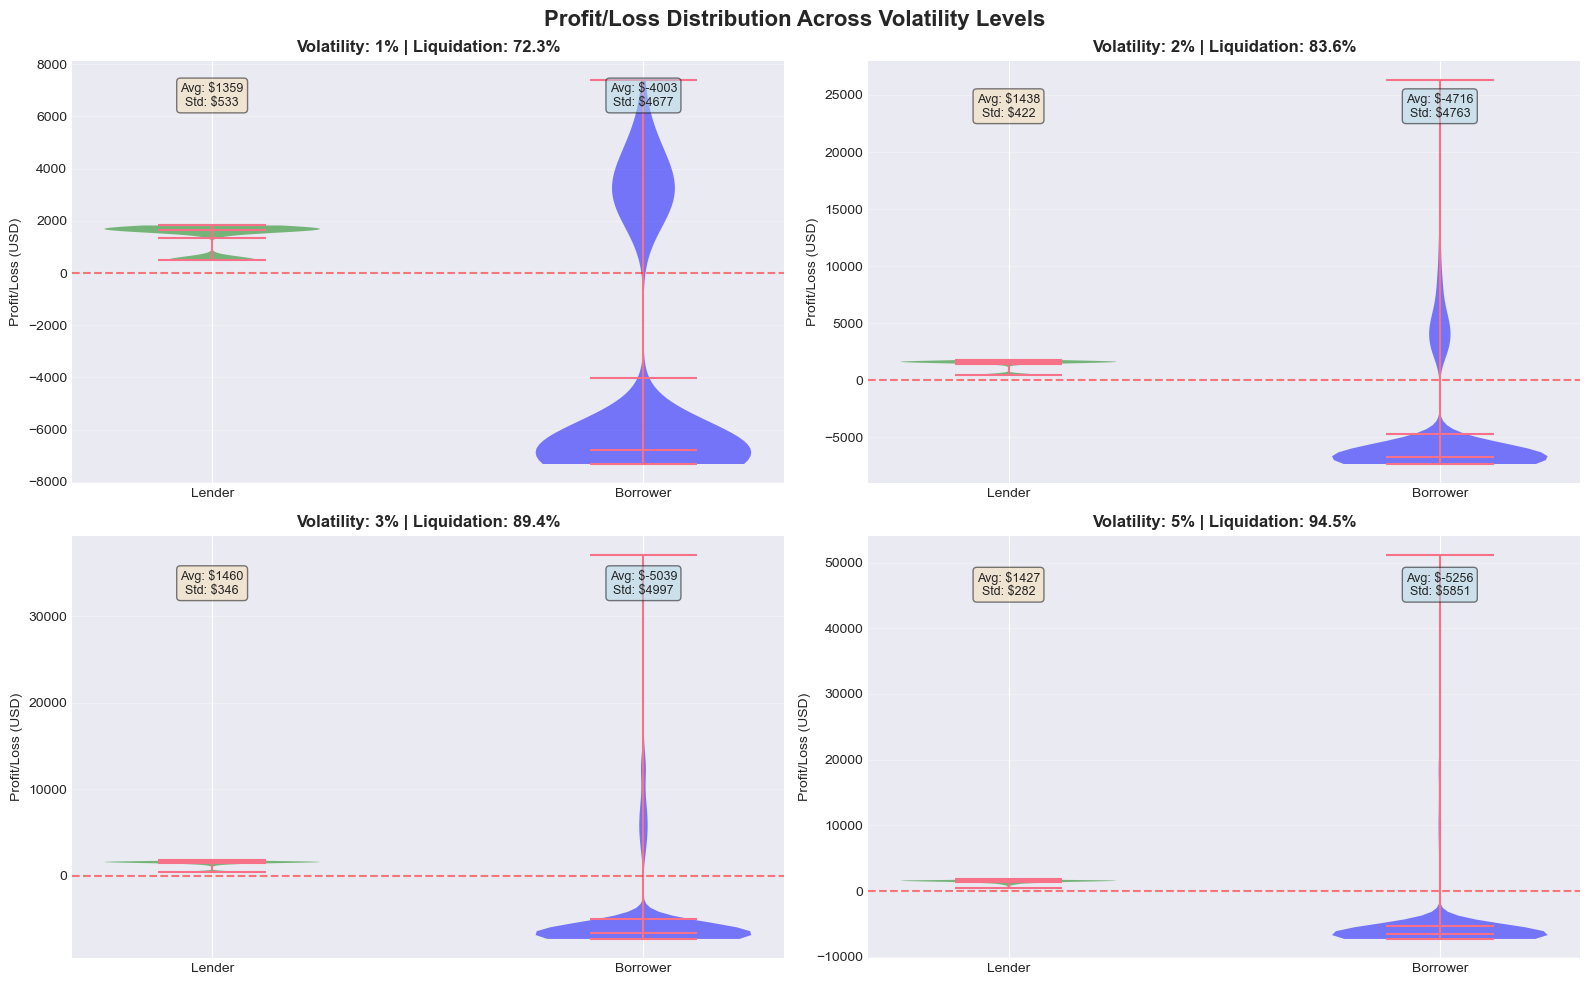

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Profit/Loss Distribution Across Volatility Levels', fontsize=16, fontweight='bold')

for idx, result in enumerate(simulation_results):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    
    # Create violin plot
    data_to_plot = [
        result['lender_profits'],
        result['borrower_outcomes']
    ]
    
    parts = ax.violinplot(data_to_plot, positions=[1, 2], 
                          showmeans=True, showmedians=True)
    
    # Color the violin plots
    colors = ['green', 'blue']
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_alpha(0.5)
    
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')
    ax.set_title(f"Volatility: {result['volatility']} | Liquidation: {result['liquidation_rate']:.1f}%", 
                fontweight='bold')
    ax.set_ylabel('Profit/Loss (USD)')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Lender', 'Borrower'])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    ax.text(1, ax.get_ylim()[1] * 0.9, 
           f"Avg: ${result['avg_lender_profit']:.0f}\nStd: ${result['lender_profit_std']:.0f}",
           ha='center', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(2, ax.get_ylim()[1] * 0.9, 
           f"Avg: ${result['avg_borrower_outcome']:.0f}\nStd: ${result['borrower_outcome_std']:.0f}",
           ha='center', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

## 6. Sensitivity Analysis: LTV Impact

Testing different LTV ratios...

LTV 120%: 100.0% liquidations, 0.00% ROI
LTV 120%: 100.0% liquidations, 0.00% ROI
LTV 130%: 100.0% liquidations, 0.00% ROI
LTV 130%: 100.0% liquidations, 0.00% ROI
LTV 140%: 93.6% liquidations, 0.64% ROI
LTV 140%: 93.6% liquidations, 0.64% ROI
LTV 150%: 87.0% liquidations, 1.30% ROI
LTV 150%: 87.0% liquidations, 1.30% ROI
LTV 160%: 75.8% liquidations, 2.42% ROI
LTV 160%: 75.8% liquidations, 2.42% ROI
LTV 180%: 58.6% liquidations, 4.14% ROI
LTV 180%: 58.6% liquidations, 4.14% ROI
LTV 200%: 38.4% liquidations, 6.16% ROI
LTV 200%: 38.4% liquidations, 6.16% ROI


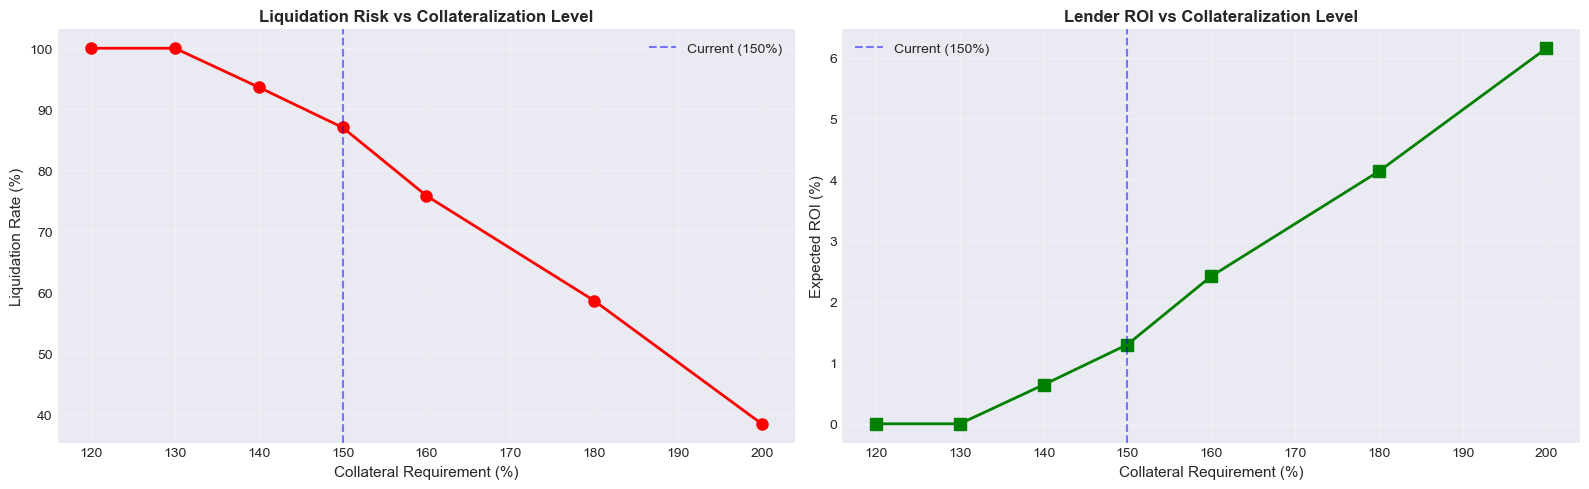


📊 LTV Sensitivity Analysis:
 ltv_ratio  collateral_req_pct  liquidation_rate  avg_lender_return  roi
       1.2               120.0             100.0                0.0 0.00
       1.3               130.0             100.0                0.0 0.00
       1.4               140.0              93.6               32.0 0.64
       1.5               150.0              87.0               65.0 1.30
       1.6               160.0              75.8              121.0 2.42
       1.8               180.0              58.6              207.0 4.14
       2.0               200.0              38.4              308.0 6.16


In [8]:
# Test different LTV ratios
LTV_RATIOS = [1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.0]  # 120% to 200%
FIXED_VOLATILITY = 0.02  # 2% volatility
NUM_SIMS_PER_LTV = 500

ltv_analysis = []

print("Testing different LTV ratios...\n")

for ltv in LTV_RATIOS:
    test_protocol = TrustLendProtocol(ltv_ratio=ltv)
    liquidations = 0
    lender_returns = []
    
    for _ in range(NUM_SIMS_PER_LTV):
        loan_df, collateral_eth, is_liquidated, _ = test_protocol.simulate_loan(
            loan_amount=LOAN_AMOUNT,
            initial_eth_price=ETH_PRICE,
            duration_days=DURATION,
            eth_price_volatility=FIXED_VOLATILITY
        )
        
        if is_liquidated:
            liquidations += 1
        
        final_interest = loan_df.iloc[-1]['interest_accrued']
        lender_returns.append(final_interest if not is_liquidated else 0)
    
    liquidation_rate = (liquidations / NUM_SIMS_PER_LTV) * 100
    avg_return = np.mean(lender_returns)
    roi = (avg_return / LOAN_AMOUNT) * 100
    
    ltv_analysis.append({
        'ltv_ratio': ltv,
        'collateral_req_pct': (ltv * 100),
        'liquidation_rate': liquidation_rate,
        'avg_lender_return': avg_return,
        'roi': roi
    })
    
    print(f"LTV {ltv*100:.0f}%: {liquidation_rate:.1f}% liquidations, {roi:.2f}% ROI")

ltv_df = pd.DataFrame(ltv_analysis)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Liquidation rate vs LTV
axes[0].plot(ltv_df['collateral_req_pct'], ltv_df['liquidation_rate'], 
            marker='o', linewidth=2, markersize=8, color='red')
axes[0].set_title('Liquidation Risk vs Collateralization Level', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Collateral Requirement (%)', fontsize=11)
axes[0].set_ylabel('Liquidation Rate (%)', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=150, color='blue', linestyle='--', alpha=0.5, label='Current (150%)')
axes[0].legend()

# ROI vs LTV
axes[1].plot(ltv_df['collateral_req_pct'], ltv_df['roi'], 
            marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_title('Lender ROI vs Collateralization Level', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Collateral Requirement (%)', fontsize=11)
axes[1].set_ylabel('Expected ROI (%)', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=150, color='blue', linestyle='--', alpha=0.5, label='Current (150%)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n📊 LTV Sensitivity Analysis:")
print(ltv_df.to_string(index=False))

## 7. Protocol-Level Financial Projections

In [9]:
# Simulate protocol with multiple loans
NUM_LOANS = 100
LOAN_SIZES = np.random.uniform(1000, 10000, NUM_LOANS)  # Random loan sizes
PROTOCOL_FEE = 0.001  # 0.1% protocol fee on each transaction

protocol_revenue = 0
total_loans_issued = 0
total_interest_paid = 0
protocol_liquidations = 0
total_volume = 0

print("Simulating protocol-level operations with 100 loans...\n")

for loan_size in LOAN_SIZES:
    loan_df, collateral_eth, is_liquidated, _ = protocol.simulate_loan(
        loan_amount=loan_size,
        initial_eth_price=ETH_PRICE,
        duration_days=np.random.randint(30, 365),  # Random duration
        eth_price_volatility=0.02
    )
    
    total_loans_issued += 1
    total_volume += loan_size
    
    if is_liquidated:
        protocol_liquidations += 1
    
    final_interest = loan_df.iloc[-1]['interest_accrued']
    total_interest_paid += final_interest
    
    # Protocol earns fee on loan origination and interest
    protocol_revenue += (loan_size * PROTOCOL_FEE) + (final_interest * PROTOCOL_FEE)

avg_loan_size = total_volume / total_loans_issued
liquidation_rate = (protocol_liquidations / total_loans_issued) * 100

print("="*70)
print("PROTOCOL-LEVEL FINANCIAL SUMMARY")
print("="*70)
print(f"\n📈 Volume Metrics:")
print(f"   Total Loans Issued: {total_loans_issued}")
print(f"   Total Lending Volume: ${total_volume:,.2f}")
print(f"   Average Loan Size: ${avg_loan_size:,.2f}")

print(f"\n💵 Revenue Metrics:")
print(f"   Total Interest Generated: ${total_interest_paid:,.2f}")
print(f"   Protocol Fee Revenue: ${protocol_revenue:,.2f}")
print(f"   Average Interest per Loan: ${total_interest_paid/total_loans_issued:,.2f}")

print(f"\n⚠️  Risk Metrics:")
print(f"   Liquidations: {protocol_liquidations} ({liquidation_rate:.2f}%)")
print(f"   Successful Loans: {total_loans_issued - protocol_liquidations} ({100-liquidation_rate:.2f}%)")

print(f"\n🎯 Protocol Efficiency:")
print(f"   Revenue per Dollar Lent: ${(protocol_revenue/total_volume)*100:.4f} (0.{PROTOCOL_FEE*10000:.0f}% fee)")
print(f"   Total Lender Returns: ${total_interest_paid:,.2f}")
print(f"   Protocol/Lender Revenue Ratio: {(protocol_revenue/total_interest_paid)*100:.2f}%")
print("\n" + "="*70)

Simulating protocol-level operations with 100 loans...

PROTOCOL-LEVEL FINANCIAL SUMMARY

📈 Volume Metrics:
   Total Loans Issued: 100
   Total Lending Volume: $562,461.29
   Average Loan Size: $5,624.61

💵 Revenue Metrics:
   Total Interest Generated: $29,030.26
   Protocol Fee Revenue: $591.49
   Average Interest per Loan: $290.30

⚠️  Risk Metrics:
   Liquidations: 66 (66.00%)
   Successful Loans: 34 (34.00%)

🎯 Protocol Efficiency:
   Revenue per Dollar Lent: $0.1052 (0.10% fee)
   Total Lender Returns: $29,030.26
   Protocol/Lender Revenue Ratio: 2.04%



## 8. Break-Even Analysis for Borrowers

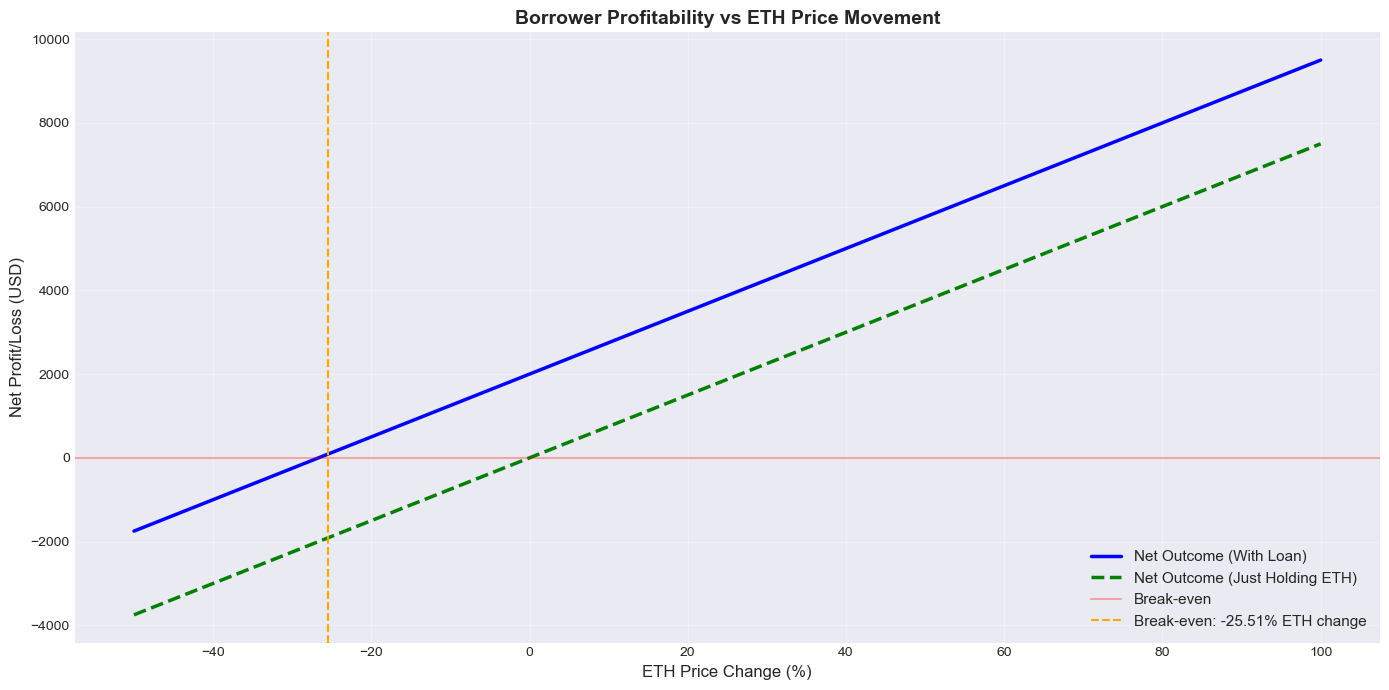


🎯 Break-Even Analysis:
   Borrower breaks even when ETH changes by: -25.51%
   Interest paid over 365 days: $500.00
   Effective interest rate: 10.0% APR

   Strategy: Borrow when expecting ETH to appreciate > 25.51%


In [10]:
# Calculate break-even point for borrowers
# Borrower profits if ETH appreciation > interest paid

ETH_APPRECIATION_RATES = np.linspace(-0.5, 1.0, 50)  # -50% to +100%
LOAN_AMOUNT_TEST = 5000
DURATION_TEST = 365

borrower_outcomes = []

for eth_change in ETH_APPRECIATION_RATES:
    initial_price = ETH_PRICE
    final_price = initial_price * (1 + eth_change)
    
    # Calculate collateral
    collateral_eth, _ = protocol.calculate_collateral_required(LOAN_AMOUNT_TEST, initial_price)
    
    # Interest paid
    interest = protocol.calculate_interest(LOAN_AMOUNT_TEST, DURATION_TEST)
    total_paid = LOAN_AMOUNT_TEST + interest
    
    # Collateral value at end
    final_collateral_value = collateral_eth * final_price
    
    # Net outcome: (collateral value - debt)
    net_outcome = final_collateral_value - total_paid
    
    # vs holding ETH without loan
    initial_collateral_value = collateral_eth * initial_price
    holding_outcome = final_collateral_value - initial_collateral_value
    
    borrower_outcomes.append({
        'eth_change_pct': eth_change * 100,
        'net_with_loan': net_outcome,
        'net_holding': holding_outcome,
        'loan_advantage': net_outcome - holding_outcome + LOAN_AMOUNT_TEST  # Add loan value used
    })

breakeven_df = pd.DataFrame(borrower_outcomes)

# Find break-even point
breakeven_idx = np.argmin(np.abs(breakeven_df['net_with_loan']))
breakeven_eth_change = breakeven_df.iloc[breakeven_idx]['eth_change_pct']

# Plot
plt.figure(figsize=(14, 7))
plt.plot(breakeven_df['eth_change_pct'], breakeven_df['net_with_loan'], 
        label='Net Outcome (With Loan)', linewidth=2.5, color='blue')
plt.plot(breakeven_df['eth_change_pct'], breakeven_df['net_holding'], 
        label='Net Outcome (Just Holding ETH)', linewidth=2.5, color='green', linestyle='--')
plt.axhline(y=0, color='red', linestyle='-', alpha=0.3, label='Break-even')
plt.axvline(x=breakeven_eth_change, color='orange', linestyle='--', 
           label=f'Break-even: {breakeven_eth_change:.2f}% ETH change')

plt.title('Borrower Profitability vs ETH Price Movement', fontweight='bold', fontsize=14)
plt.xlabel('ETH Price Change (%)', fontsize=12)
plt.ylabel('Net Profit/Loss (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Break-Even Analysis:")
print(f"   Borrower breaks even when ETH changes by: {breakeven_eth_change:.2f}%")
print(f"   Interest paid over {DURATION_TEST} days: ${protocol.calculate_interest(LOAN_AMOUNT_TEST, DURATION_TEST):,.2f}")
print(f"   Effective interest rate: {protocol.interest_rate * 100}% APR")
print(f"\n   Strategy: Borrow when expecting ETH to appreciate > {abs(breakeven_eth_change):.2f}%")

## 9. Summary Dashboard

In [11]:
print("\n" + "="*90)
print(" "*25 + "TrustLend PROTOCOL SUMMARY")
print("="*90)

print("\n📋 PROTOCOL PARAMETERS:")
print(f"   • Interest Rate: {protocol.interest_rate * 100}% APR (Fixed)")
print(f"   • LTV Ratio: {protocol.ltv_ratio * 100}% (Over-collateralized)")
print(f"   • Liquidation Threshold: {protocol.liquidation_threshold * 100}%")
print(f"   • Collateral Asset: ETH")
print(f"   • Loan Currency: TDAI (Stablecoin)")

print("\n💡 KEY FINDINGS FROM SIMULATIONS:")
print(f"   • At 2% daily volatility: ~{simulation_results[1]['liquidation_rate']:.1f}% liquidation risk")
print(f"   • Average lender profit: ${simulation_results[1]['avg_lender_profit']:,.2f} per loan")
print(f"   • Expected lender ROI: ~{(simulation_results[1]['avg_lender_profit']/LOAN_AMOUNT)*100:.2f}%")
print(f"   • Higher LTV = Lower liquidation risk but requires more collateral")
print(f"   • Borrowers profit when ETH appreciates > {abs(breakeven_eth_change):.2f}%")

print("\n📊 RISK ASSESSMENT:")
print("   • Low Volatility (1%):  Minimal liquidation risk, stable returns")
print("   • Medium Volatility (2-3%): Moderate risk, good for both parties")
print("   • High Volatility (5%+): High liquidation risk, requires higher LTV")

print("\n🎯 RECOMMENDATIONS:")
print("   FOR LENDERS:")
print("   • Diversify across multiple loans to reduce risk")
print("   • Monitor LTV ratios in real-time")
print("   • Expected return: 8-10% APR with current parameters")

print("\n   FOR BORROWERS:")
print("   • Use loan when bullish on ETH price")
print("   • Keep extra collateral buffer for volatility")
print("   • Consider partial repayments to reduce liquidation risk")

print("\n   FOR PROTOCOL:")
print("   • Current 150% LTV provides good balance")
print("   • Consider dynamic interest rates based on utilization")
print("   • Implement liquidation penalty fee (5-10%) for protocol revenue")

print("\n" + "="*90)
print("\n✅ Analysis complete! This model demonstrates TrustLend's financial viability.")
print("   The protocol can sustain itself with proper risk management and attracts")
print("   both lenders (consistent returns) and borrowers (leverage opportunities).")
print("\n" + "="*90)


                         TrustLend PROTOCOL SUMMARY

📋 PROTOCOL PARAMETERS:
   • Interest Rate: 10.0% APR (Fixed)
   • LTV Ratio: 150.0% (Over-collateralized)
   • Liquidation Threshold: 75.0%
   • Collateral Asset: ETH
   • Loan Currency: TDAI (Stablecoin)

💡 KEY FINDINGS FROM SIMULATIONS:
   • At 2% daily volatility: ~83.6% liquidation risk
   • Average lender profit: $1,438.31 per loan
   • Expected lender ROI: ~28.77%
   • Higher LTV = Lower liquidation risk but requires more collateral
   • Borrowers profit when ETH appreciates > 25.51%

📊 RISK ASSESSMENT:
   • Low Volatility (1%):  Minimal liquidation risk, stable returns
   • Medium Volatility (2-3%): Moderate risk, good for both parties
   • High Volatility (5%+): High liquidation risk, requires higher LTV

🎯 RECOMMENDATIONS:
   FOR LENDERS:
   • Diversify across multiple loans to reduce risk
   • Monitor LTV ratios in real-time
   • Expected return: 8-10% APR with current parameters

   FOR BORROWERS:
   • Use loan when bulli

## 10. Export Results for Further Analysis

In [12]:
# Save simulation results to CSV for external analysis
loan_df.to_csv('trustlend_single_loan_simulation.csv', index=False)
results_df.to_csv('trustlend_monte_carlo_results.csv', index=False)
ltv_df.to_csv('trustlend_ltv_sensitivity.csv', index=False)
breakeven_df.to_csv('trustlend_borrower_breakeven.csv', index=False)

print("✅ Results exported to CSV files:")
print("   • trustlend_single_loan_simulation.csv")
print("   • trustlend_monte_carlo_results.csv")
print("   • trustlend_ltv_sensitivity.csv")
print("   • trustlend_borrower_breakeven.csv")

✅ Results exported to CSV files:
   • trustlend_single_loan_simulation.csv
   • trustlend_monte_carlo_results.csv
   • trustlend_ltv_sensitivity.csv
   • trustlend_borrower_breakeven.csv
